Goal: simulate consumer resource model and find parameter values


\begin{align*}
    \dot{x} &=  \bigg[\gamma_A r_A \frac{A}{K_A + A} + \gamma_I r_I \frac{I}{K_I + I} \bigg] \frac{\tilde{C}}{K_C + \tilde{C}}x - \mu x\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x\\
    \dot{I} &= \bigg[r_A \frac{A}{K_A + A} - r_I \frac{I}{K_I + I} \bigg]x\\
    \dot{\tilde{C}} &= - \frac{\tilde{C}}{K_C + \tilde{C}} x
\end{align*}

Here, $\tilde{C} = C/r_c$ is the normalized amount of limiting nutrient. Here, we then wish to fit rate and uptake parameters ($r$ and $\gamma$) as well as the initial biomass $x(0)$. We will use a sensitivity analysis to select $C(0)$ as well as each affinity, $K$.

In [1]:
import numpy as np

def RHS(x, A, I, C, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu):
    dx = (gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x*C/(K_C + C) - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    dC = - x*C/(K_C + C)
    return dx, dA, dI, dC

#use RK4
def timestep(x_n, A_n, I_n, C_n, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt):
    k_1 = RHS(x_n, A_n, I_n, C_n, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_2 = RHS(x_n + dt*k_1[0]/2, A_n + dt*k_1[1]/2, I_n + dt*k_1[2]/2, C_n + dt*k_1[3]/2, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_3 = RHS(x_n + dt*k_2[0]/2, A_n + dt*k_2[1]/2, I_n + dt*k_2[2]/2, C_n + dt*k_2[3]/2, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    k_4 = RHS(x_n + dt*k_3[0], A_n + dt*k_3[1], I_n + dt*k_3[2], C_n + dt*k_3[3], gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu)
    x_new = x_n + (dt/6)*(k_1[0] + 2*k_2[0] + 2*k_3[0] + k_4[0])
    A_new = A_n + (dt/6)*(k_1[1] + 2*k_2[1] + 2*k_3[1] + k_4[1])
    I_new = I_n + (dt/6)*(k_1[2] + 2*k_2[2] + 2*k_3[2] + k_4[2])
    C_new = C_n + (dt/6)*(k_1[3] + 2*k_2[3] + 2*k_3[3] + k_4[3])
    return x_new, A_new, I_new, C_new
    
def simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T):
    N = int(T/dt)
    x = np.zeros(N); x[0] = x_0
    A = np.zeros(N); A[0] = A_0
    I = np.zeros(N); I[0] = I_0
    C = np.zeros(N); C[0] = C_0
    for i in range(N-1):
        new = timestep(x[i], A[i], I[i], C[i], gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt)
        x[i + 1] = new[0]
        A[i + 1] = new[1]
        I[i + 1] = new[2]
        C[i + 1] = new[3]
        
    return x, A, I, C
    
    

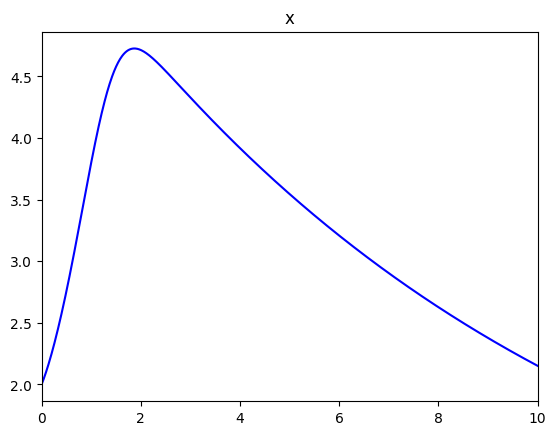

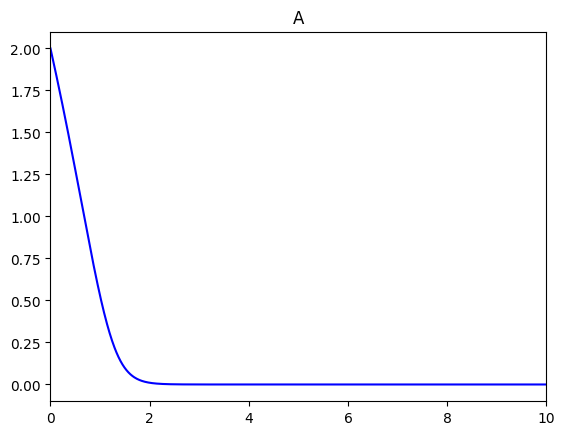

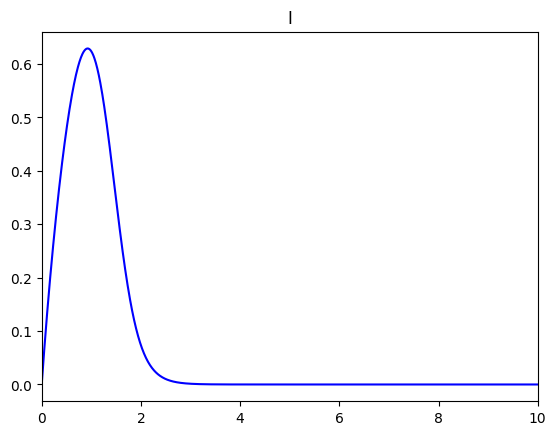

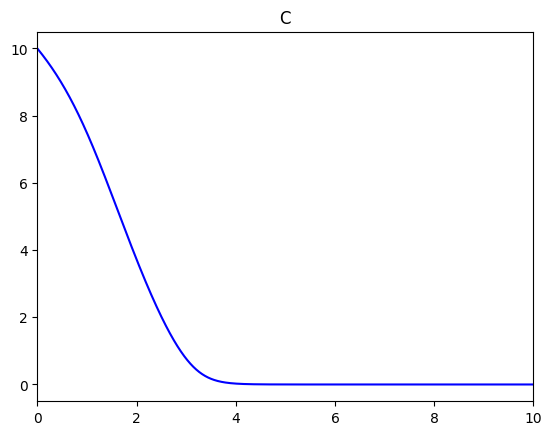

In [2]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01
T = 10
x_0 = 2
A_0 = 2
I_0 = 0
C_0 = 10
gamma_A = 1
gamma_I = 1
r_A = 1
r_I = 1
K_A = K_I = K_C = 1
mu = 0.1

x, A, I, C = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T)
t = np.linspace(0, T, int(T/dt))

plt.plot(t, x, color = 'blue')
plt.xlim(0,T)
plt.title('x')
plt.show()
plt.plot(t, A, color = 'blue')
plt.xlim(0,T)
plt.title('A')
plt.show()
plt.plot(t, I, color = 'blue')
plt.xlim(0,T)
plt.title('I')
plt.show()
plt.plot(t, C, color = 'blue')
plt.xlim(0,T)
plt.title('C')
plt.show()

Run a curvefit.

Optimized parameters:
gamma_A = 0.9657
gamma_I = 0.0001
r_A = 0.4960
r_I = 16.6276


(0.0, 9.0)

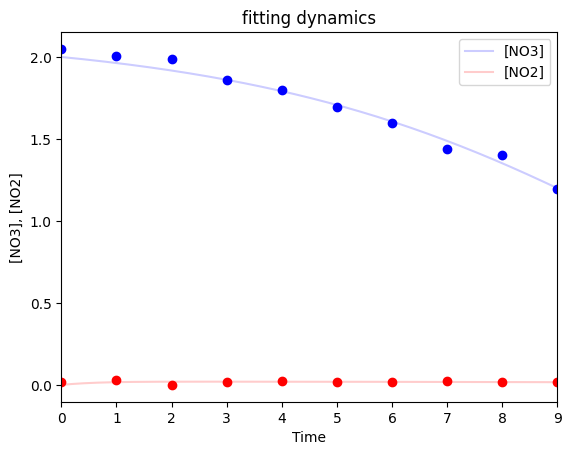

In [66]:
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils

native = 5 #which native soil (0 through 9)
pert = 3 #which perturbed soil (0 through 10)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
sample = samples_from_soils(soils[native])[pert]


t_data = np.linspace(0,19,20)
function = get_function(sample)

A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
    
A_data = A_data/3
I_data = I_data/3

y_data = np.concatenate([A_data, I_data])

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

def model(t, gamma_A, gamma_I, r_A, r_I):
    
    indices = np.linspace(0,int(9/dt-1),10).astype(int)
    
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C, mu, dt, T)
    A_out = A[indices]
    I_out = I[indices]
    
    return np.concatenate([A_out, I_out])

initial_guess = [1.0, 1.0, 0.1, 0.1] 


bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])


popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)  

print("Optimized parameters:")
print(f"gamma_A = {popt[0]:.4f}")
print(f"gamma_I = {popt[1]:.4f}")
print(f"r_A = {popt[2]:.4f}")
print(f"r_I = {popt[3]:.4f}")

x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)


t = np.linspace(0,9,N)
t_scatter = np.linspace(0,9,10)


plt.plot(t, A, color = 'Blue', alpha = 0.2, label = '[NO3]')
plt.plot(t, I, color = 'Red', alpha = 0.2, label = '[NO2]')
plt.title('fitting dynamics')
plt.scatter(t_scatter, A_data, color = 'Blue')
plt.scatter(t_scatter, I_data, color = 'Red')
plt.xlabel('Time')
plt.legend()
plt.ylabel('[NO3], [NO2]')
plt.xlim(0,9)

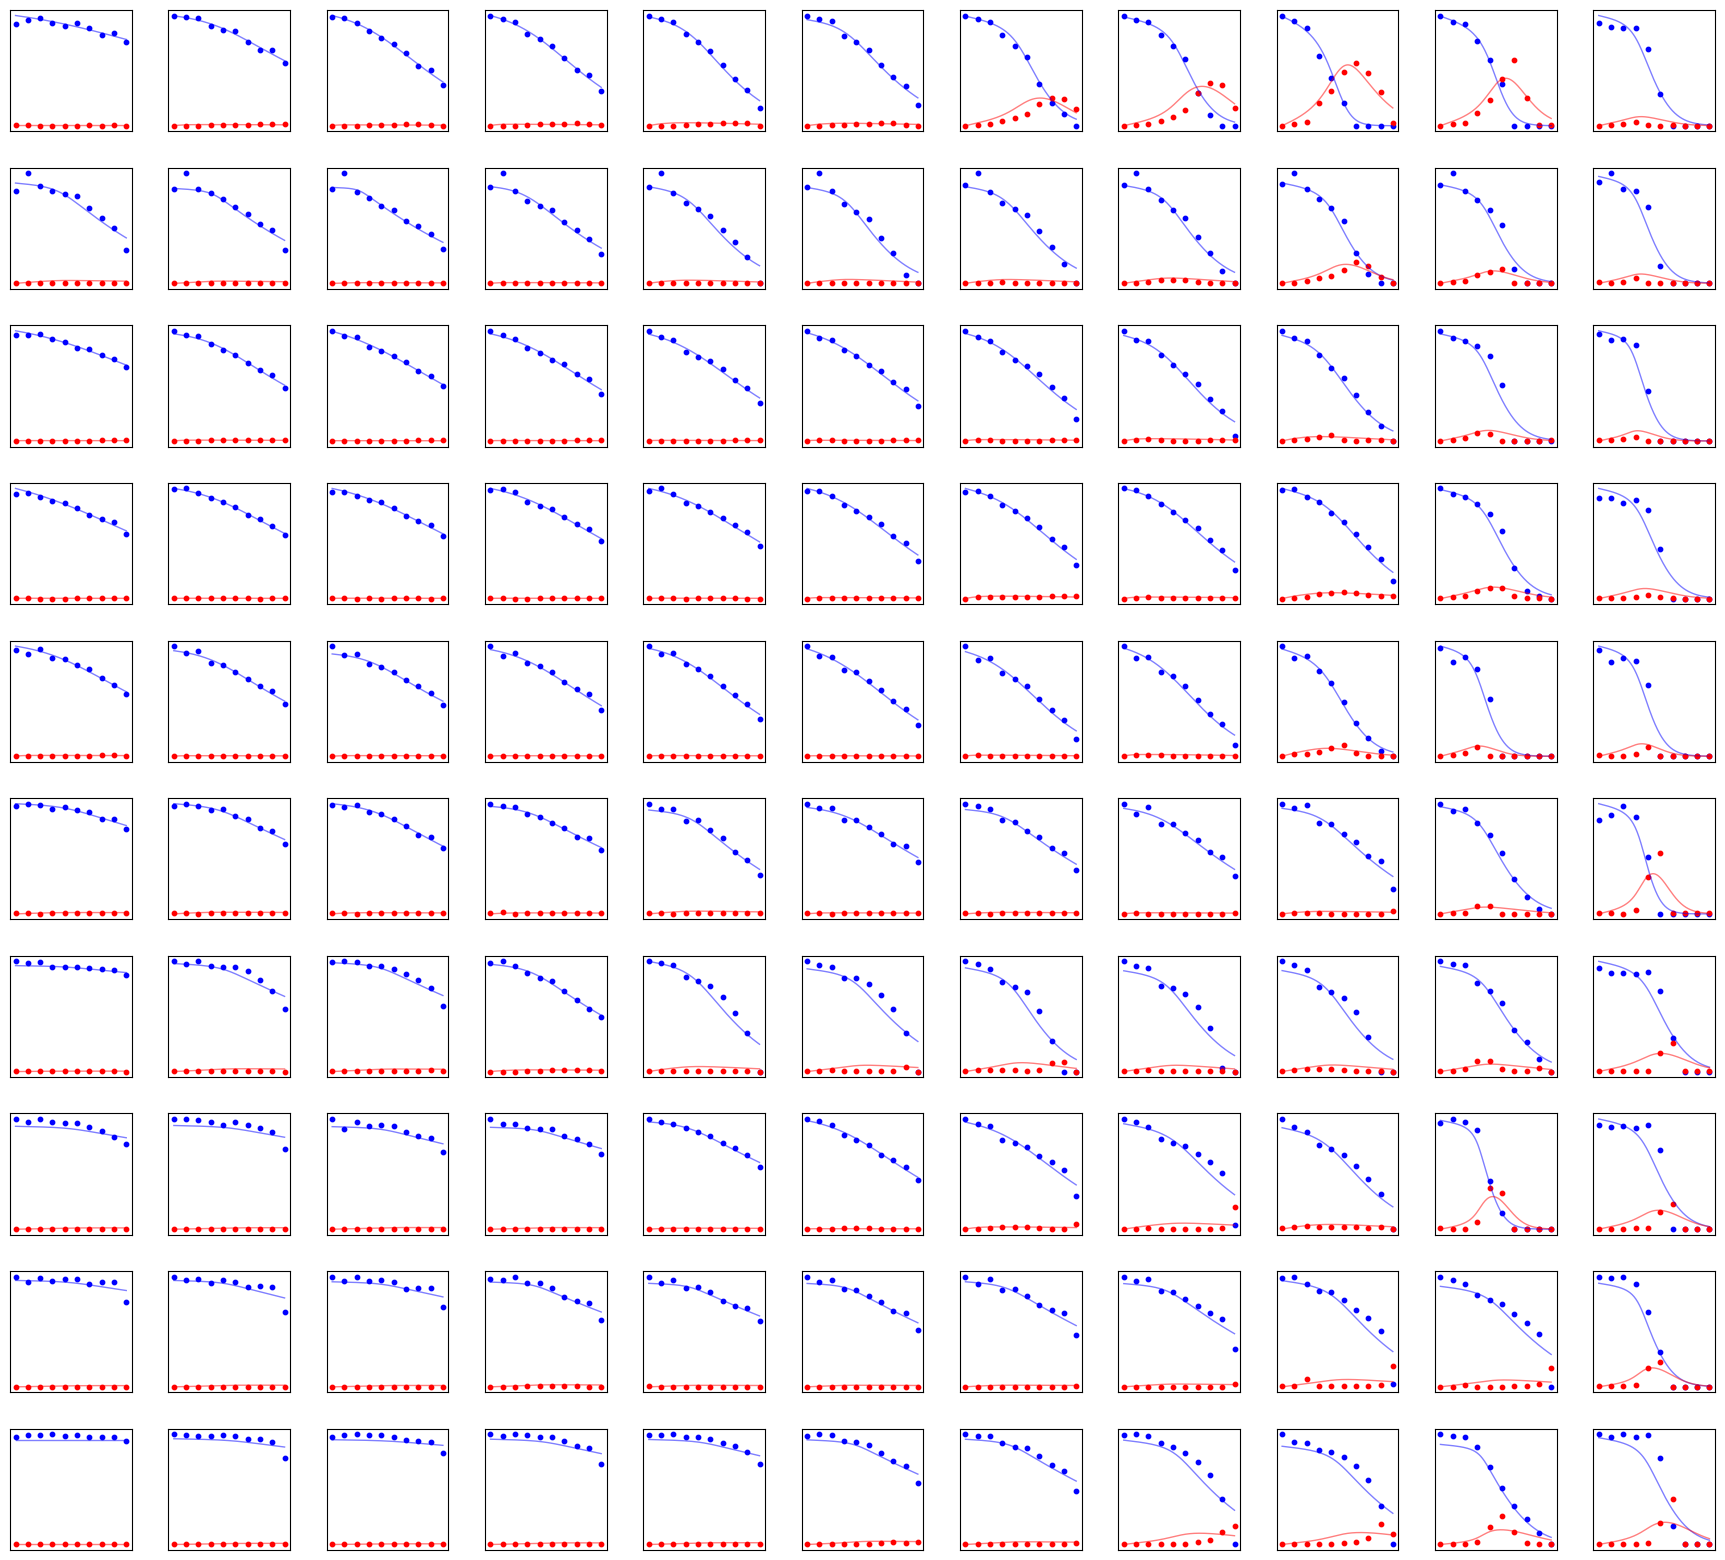

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils

# Initialize figure
fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Constants and initial parameters
t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.2
A_0 = 2
I_0 = 0
C_0 = 1
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        function = get_function(sample)
        
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.0001, 0.0001, 0.0001, 0.0001], [100, 100, 100, 100])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], 
                              popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Repeat but for CHL +

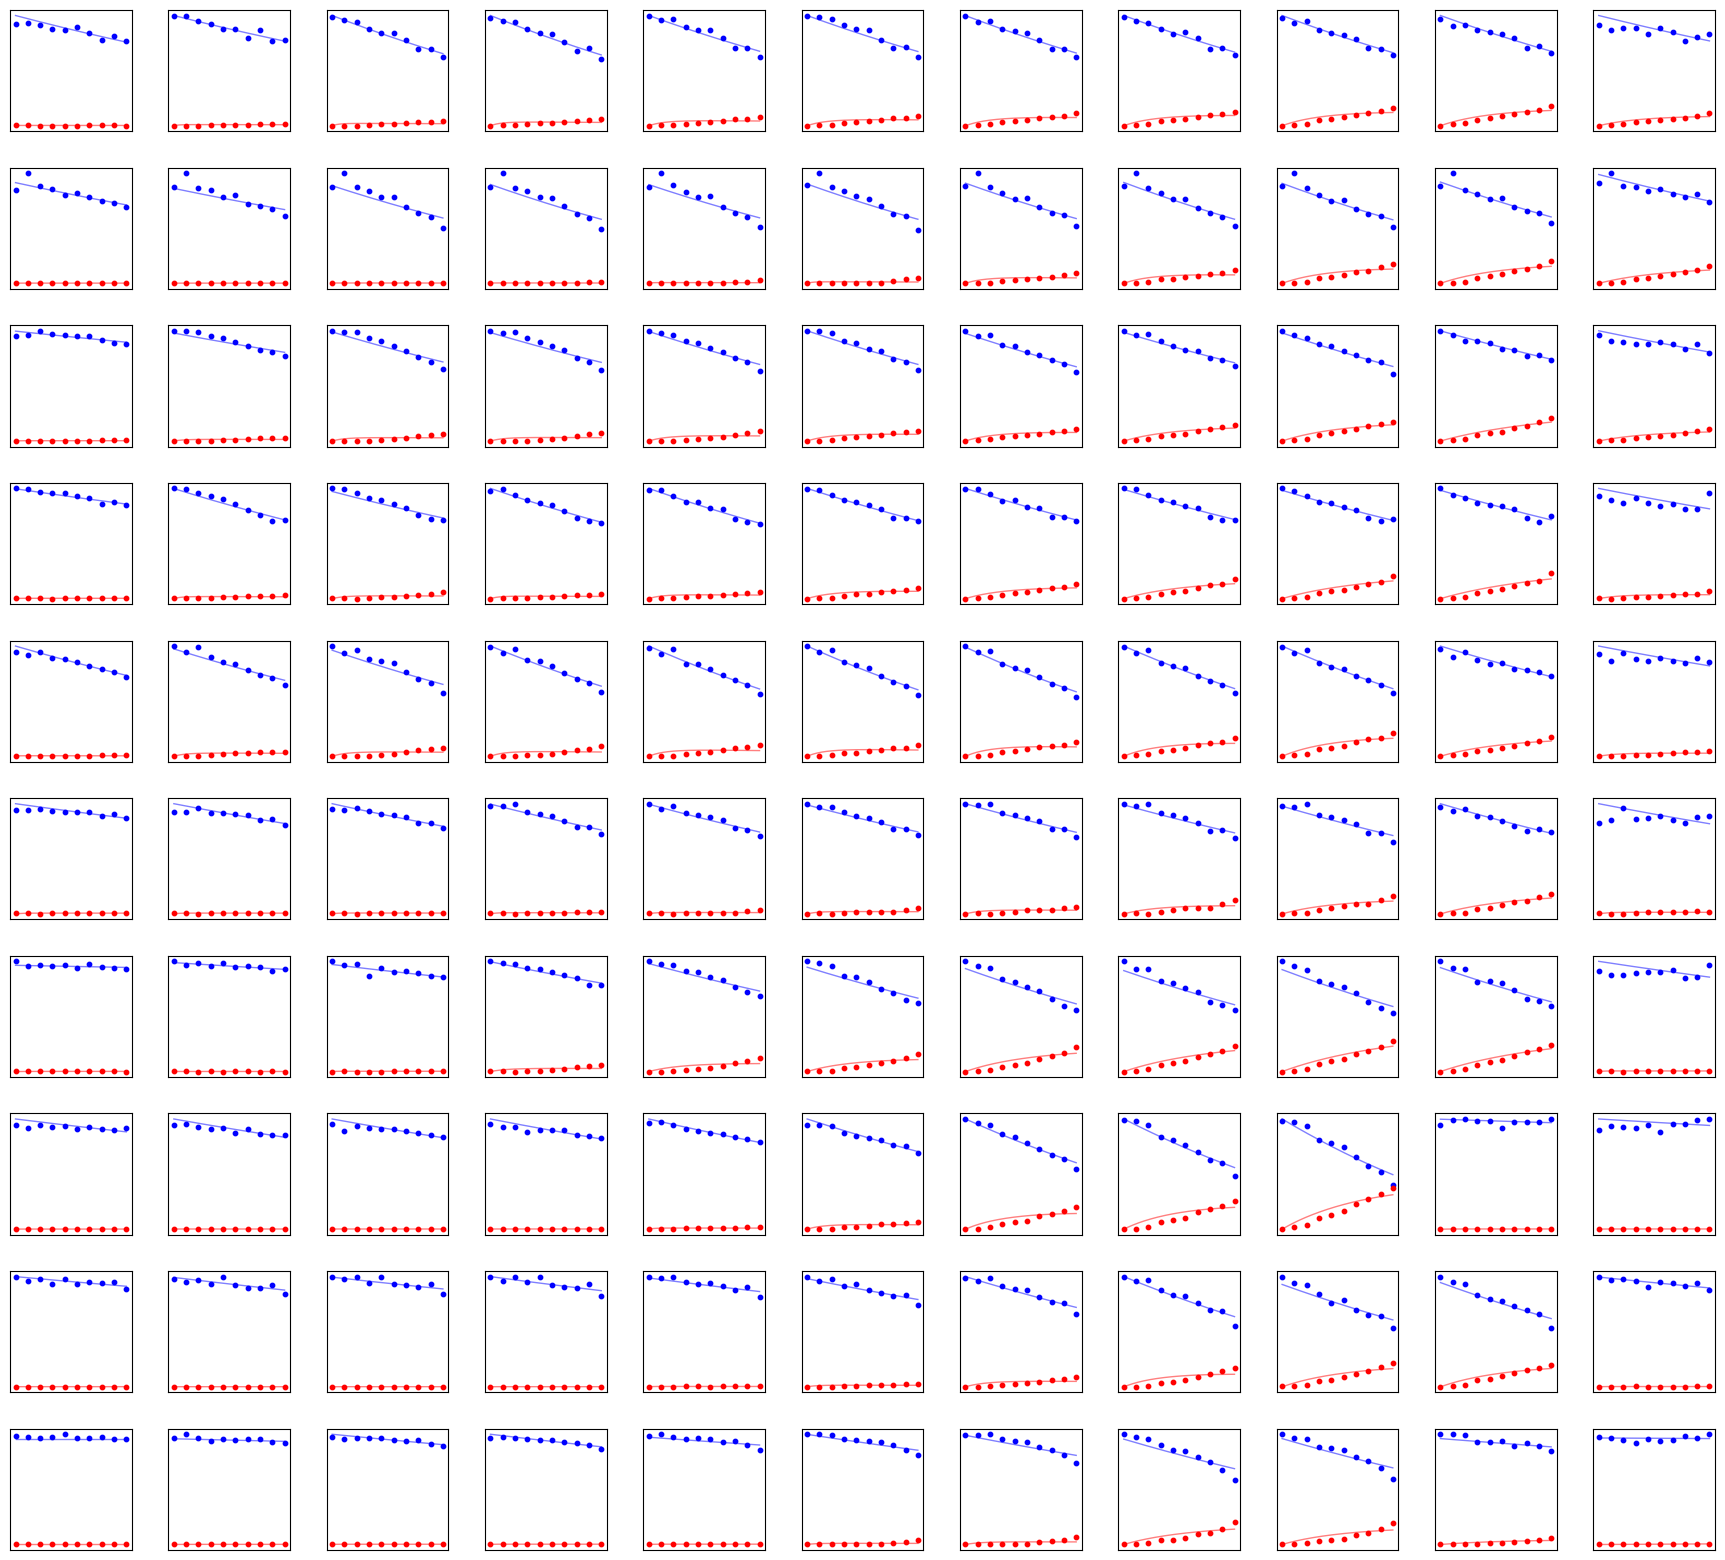

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mgsa.io import get_function, samples_from_soils


fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 3
K_A = K_I = K_C = 1
mu = 0.01 
dt = 0.05
T = 9
N = int(T/dt)

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        function = get_function(sample, drug = 'CHL')
        
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.0001, 0.0001,], [100, 100])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, 0, 0, popt[0], popt[1],  K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Now with both drug and no drug

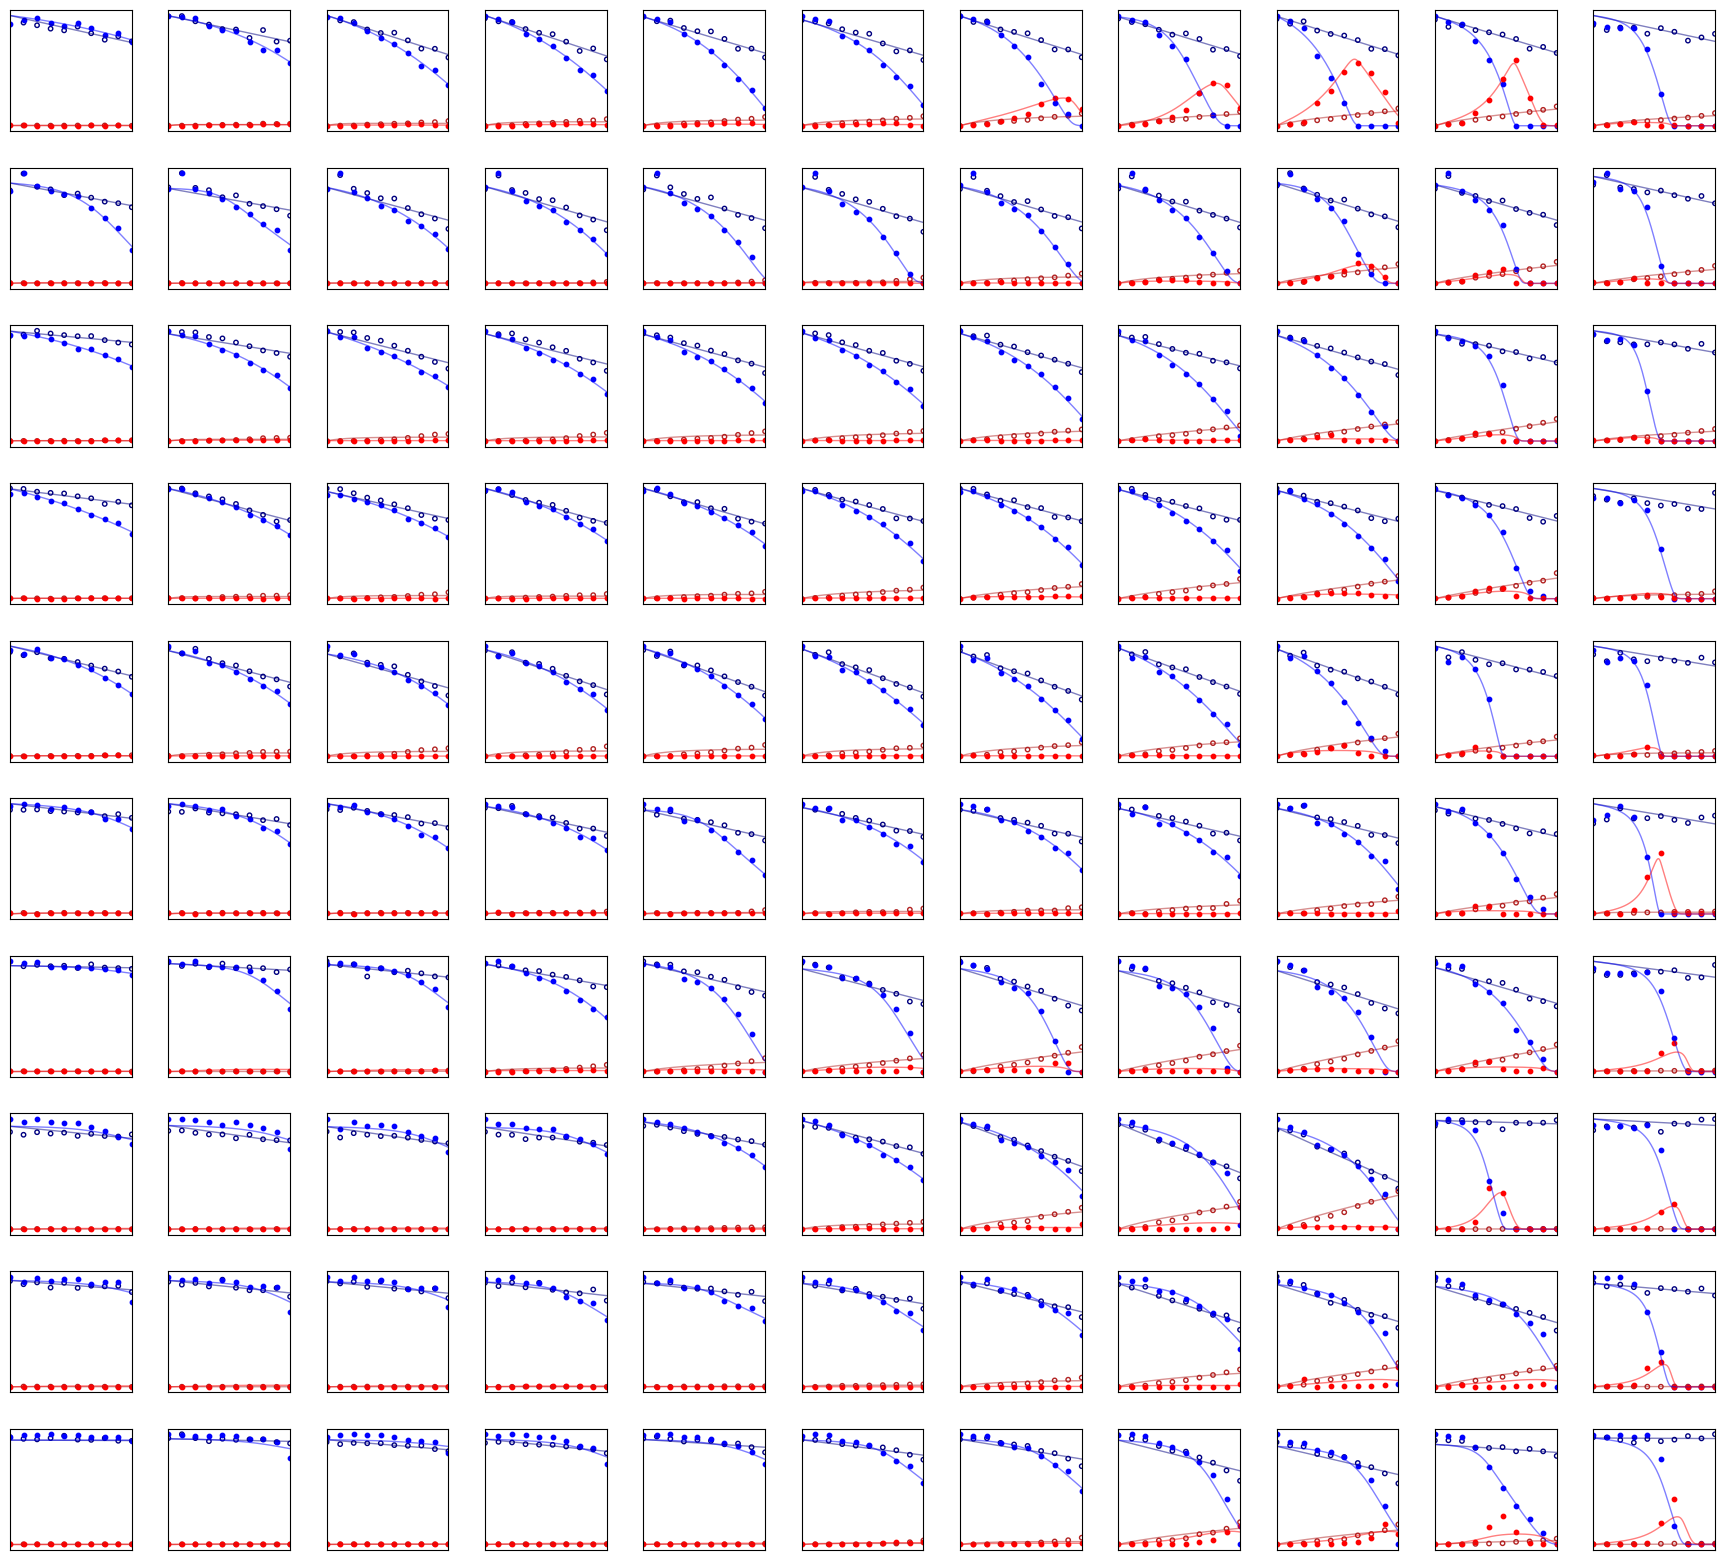

In [4]:

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 2
K_A = 0.1
K_I = 0.1
K_C = 1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,6))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, 0, 0, popt[0], popt[1],  K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_A, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, gamma_A, gamma_I, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1, 0.1]
        bounds = ([0.001, 0.001, 0.001, 0.001], [10, 10, 10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        param_values[native, pert][5] = popt[3]
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, popt[0], popt[1], 
                              popt[2], popt[3], K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Need to constrain global parameters

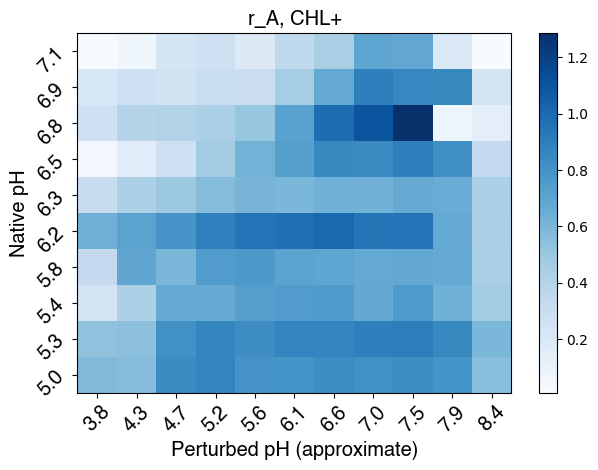

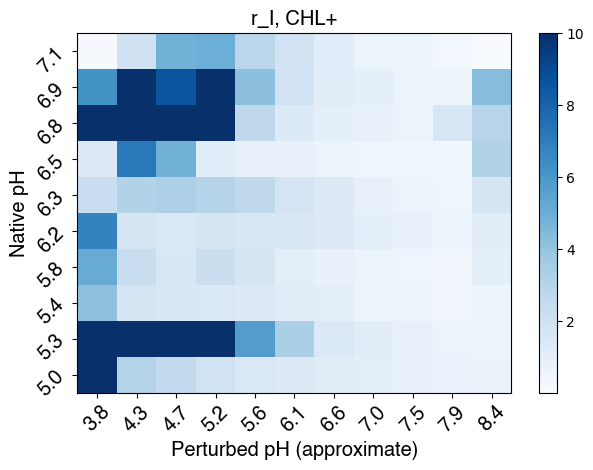

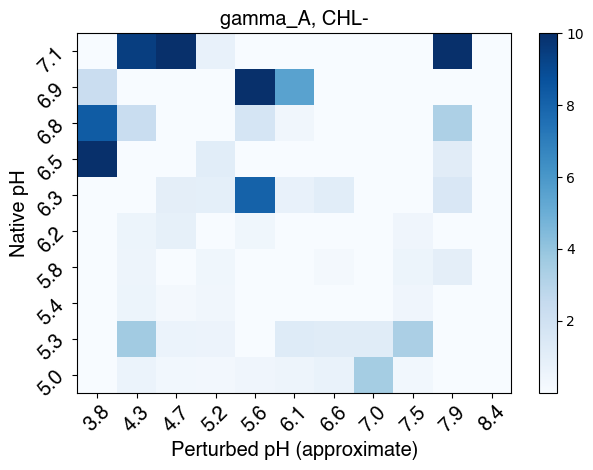

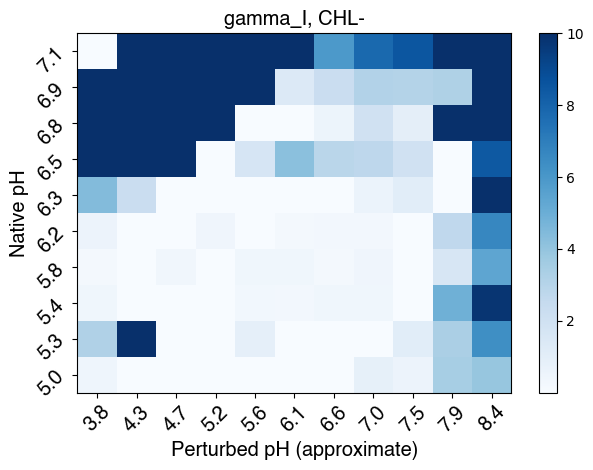

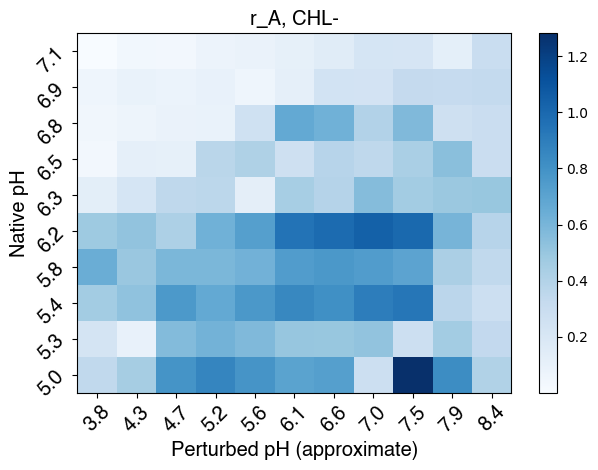

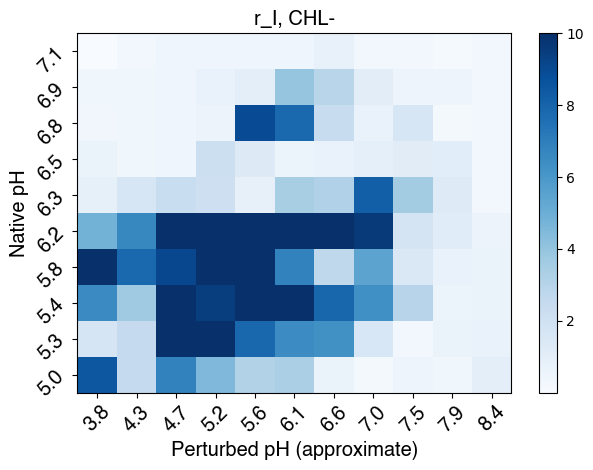

(8, 10):  [ 0.0746038   1.59727914  3.27428766 10.          0.26629932  0.19479308]
(7,  7):  [8.51226102e-01 5.96230326e-01 1.00000001e-03 2.87967377e+00
 3.79138809e-01 6.92263248e-01]
(2,  2):  [0.53993422 9.99999999 3.62064687 9.99999998 0.09297445 2.50413617]


In [5]:

from mgsa.helpers import plot
plot(param_values[:,:,0], 'r_A, CHL+')
plot(param_values[:,:,1], 'r_I, CHL+')
plot(param_values[:,:,2], 'gamma_A, CHL-')
plot(param_values[:,:,3], 'gamma_I, CHL-')
plot(param_values[:,:,4], 'r_A, CHL-')
plot(param_values[:,:,5], 'r_I, CHL-')

print('(8, 10): ', param_values[7,9,:])
print('(7,  7): ', param_values[6,6,:])
print('(2,  2): ', param_values[1,1,:])

param_1 = param_values[1,1,:]
param_2 = param_values[6,6,:]
param_3 = param_values[7,9,:]

Fit global parameters using three representative samples (8, 10), (7, 7), (2, 2)

C_0 2.0381713367706613
K_A 0.10473699076342076
K_I 0.10173500993758121
K_C 0.9883965787824828
x_0 0.09884230661916026


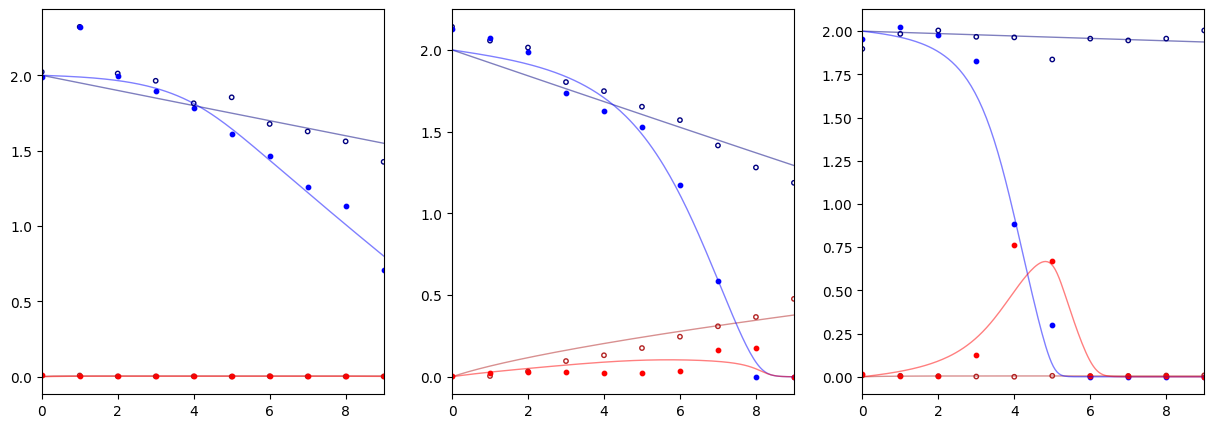

In [6]:
t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

#x_0 = 1
mu = 0
A_0 = 2
I_0 = 0

dt = 0.05
T = 9
N = int(T/dt)

t = np.linspace(0, T, int(T/dt))

## first gather data for 3 cases 

native = 1
pert = 1

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_1 = A_data_drug/3
I_data_drug_1 = I_data_drug/3
y_data_drug_1 = np.concatenate([A_data_drug_1, I_data_drug_1])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_1 = A_data/3
I_data_1 = I_data/3
y_data_1 = np.concatenate([A_data_1, I_data_1])

native = 6
pert = 6

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_2 = A_data_drug/3
I_data_drug_2 = I_data_drug/3
y_data_drug_2 = np.concatenate([A_data_drug_2, I_data_drug_2])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_2 = A_data/3
I_data_2 = I_data/3
y_data_2 = np.concatenate([A_data_2, I_data_2])

native = 7
pert = 9

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_3 = A_data_drug/3
I_data_drug_3 = I_data_drug/3
y_data_drug_3 = np.concatenate([A_data_drug_3, I_data_drug_3])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_3 = A_data/3
I_data_3 = I_data/3
y_data_3 = np.concatenate([A_data_3, I_data_3])

y_data = np.concatenate([y_data_drug_1, y_data_1, y_data_drug_2, y_data_2, y_data_drug_3, y_data_3])

##now create a simulation for the model to compare with

def model(t, C_0, K_A, K_I, K_C, x_0):
    
    
    indices = np.linspace(0, int(9/dt-1), 10).astype(int)
    
    #first simulate case 1 with drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                            param_1[0], param_1[1], K_A, K_I, K_C, mu, dt, T)
    
    A_1_drug = A[indices]
    I_1_drug = I[indices]
    
    #next simulate case 1 with no drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, param_1[2], param_1[3], 
                            param_1[4], param_1[5], K_A, K_I, K_C, mu, dt, T)
    A_1 = A[indices]
    I_1 = I[indices]
    
    #next simulate case 2 with drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                            param_2[0], param_2[1], K_A, K_I, K_C, mu, dt, T)
    
    A_2_drug = A[indices]
    I_2_drug = I[indices]
    
    #next simulate case 2 with no drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, param_2[2], param_2[3], 
                            param_2[4], param_2[5], K_A, K_I, K_C, mu, dt, T)
    A_2 = A[indices]
    I_2 = I[indices]
    
    #next simulate case 3 with drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                            param_3[0], param_3[1], K_A, K_I, K_C, mu, dt, T)
    
    A_3_drug = A[indices]
    I_3_drug = I[indices]
    
    #next simulate case 3 with no drug
    _, A, I, _ = simulate(x_0, A_0, I_0, C_0, param_3[2], param_3[3], 
                            param_3[4], param_3[5], K_A, K_I, K_C, mu, dt, T)
    A_3 = A[indices]
    I_3 = I[indices]
    
    
    
    
    return np.concatenate([A_1_drug, I_1_drug, A_1, I_1, A_2_drug, I_2_drug, A_2, I_2, A_3_drug, I_3_drug, A_3, I_3])


t_data = np.linspace(0,119, 120)
initial_guess = [1.0, 1.0, 1.0, 1.0, 1.0]
bounds = ([0.01, 0.01, 0.01, 0.01, 0.0001], [10, 10, 10, 10, 10])

popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)


#collect simulated data

_, A_1_drug, I_1_drug, _ = simulate(popt[4], A_0, I_0, 0, 0, popt[0], param_1[0], param_1[1], popt[1], popt[2], popt[3], mu, dt, T)
_, A_1, I_1, _ = simulate(popt[4], A_0, I_0, popt[0], param_1[2], param_1[3], param_1[4], param_1[5], popt[1], popt[2], popt[3], mu, dt, T)

_, A_2_drug, I_2_drug, _ = simulate(popt[4], A_0, I_0, 0, 0, popt[0], param_2[0], param_2[1], popt[1], popt[2], popt[3], mu, dt, T)
_, A_2, I_2, _ = simulate(popt[4], A_0, I_0, popt[0], param_2[2], param_2[3], param_2[4], param_2[5], popt[1], popt[2], popt[3], mu, dt, T)

_, A_3_drug, I_3_drug, _ = simulate(popt[4], A_0, I_0, 0, 0, popt[0], param_3[0], param_3[1], popt[1], popt[2], popt[3], mu, dt, T)
_, A_3, I_3, _ = simulate(popt[4], A_0, I_0, popt[0], param_3[2], param_3[3], param_3[4], param_3[5], popt[1], popt[2], popt[3], mu, dt, T)


##plot everything 

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

t_scatter = np.linspace(0, 9, 10)
t = np.linspace(0,9,N)

ax = axs[0]

ax.plot(t, A_1_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_1_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_1, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_1, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_1, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_1, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_1, color='Blue', s=10)
ax.scatter(t_scatter, I_data_1, color='Red', s=10)
ax.set_xlim(0,9)


ax = axs[1]

ax.plot(t, A_2_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_2_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_2, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_2, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_2, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_2, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_2, color='Blue', s=10)
ax.scatter(t_scatter, I_data_2, color='Red', s=10)
ax.set_xlim(0,9)

ax = axs[2]

ax.plot(t, A_3_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_3_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_3, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_3, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_3, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_3, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_3, color='Blue', s=10)
ax.scatter(t_scatter, I_data_3, color='Red', s=10)
ax.set_xlim(0,9)


print('C_0', popt[0])
print('K_A', popt[1])
print('K_I', popt[2])
print('K_C', popt[3])
print('x_0', popt[4])


# Theories

# Theory: Biomass only comes from Nitrite Reduction

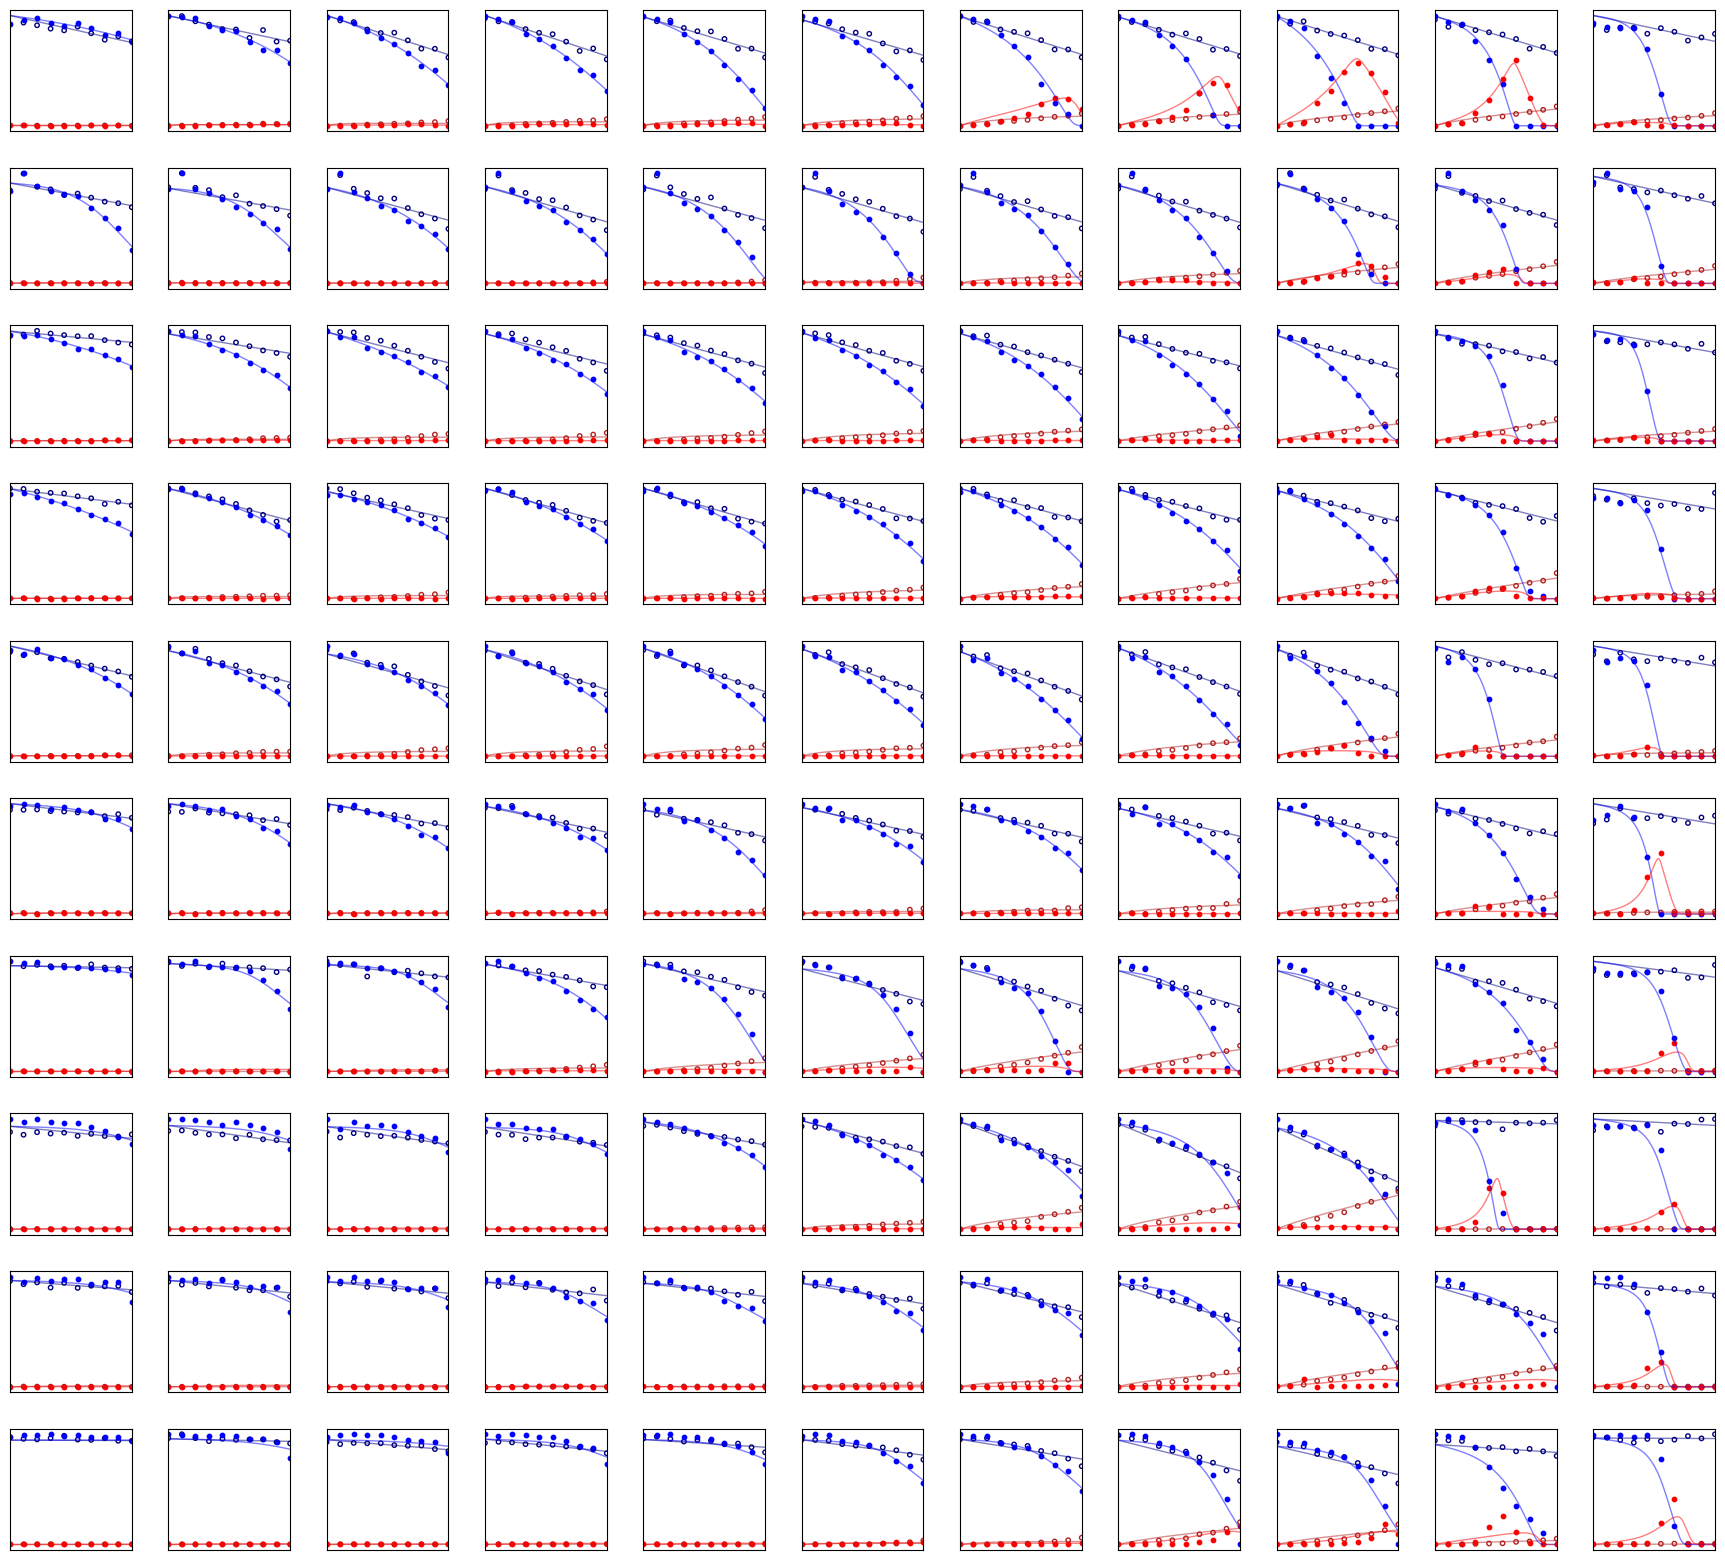

In [7]:

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
C_0 = 2
K_A = 0.1
K_I = 0.1
K_C = 1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,5))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, 0,
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, 0, 0, popt[0], popt[1],  K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I, _ = simulate(x_0, A_0, I_0, C_0, 0, gamma_I, 
                                 r_A, r_I, K_A, K_I, K_C, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1]
        bounds = ([0.001, 0.001, 0.001], [10, 10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        
        x, A, I, C = simulate(x_0, A_0, I_0, C_0, 0, popt[0], 
                              popt[1], popt[2], K_A, K_I, K_C, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

# Theory: No limiting Nutrient, Growth only from Nitrite 

\begin{align*}
    \dot{x} &= \gamma r_I \frac{I}{K_I + I} x\\
    \dot{A} &= -r_A \frac{A}{K_A + A} x\\
    \dot{I} &= \bigg[r_A \frac{A}{K_A + A} - r_I \frac{I}{K_I + I} \bigg]x
\end{align*}

In [203]:
import numpy as np

def RHS_v2(x, A, I, gamma_I, r_A, r_I, K_A, K_I, mu):
    dx = (gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x - mu*x
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    return dx, dA, dI

#use RK4
def timestep_v2(x_n, A_n, I_n, gamma_I, r_A, r_I, K_A, K_I, mu, dt):
    k_1 = RHS_v2(x_n, A_n, I_n, gamma_I, r_A, r_I, K_A, K_I, mu)
    k_2 = RHS_v2(x_n + dt*k_1[0]/2, A_n + dt*k_1[1]/2, I_n + dt*k_1[2]/2, gamma_I, r_A, r_I, K_A, K_I, mu)
    k_3 = RHS_v2(x_n + dt*k_2[0]/2, A_n + dt*k_2[1]/2, I_n + dt*k_2[2]/2, gamma_I, r_A, r_I, K_A, K_I, mu)
    k_4 = RHS_v2(x_n + dt*k_3[0], A_n + dt*k_3[1], I_n + dt*k_3[2], gamma_I, r_A, r_I, K_A, K_I, mu)
    x_new = x_n + (dt/6)*(k_1[0] + 2*k_2[0] + 2*k_3[0] + k_4[0])
    A_new = A_n + (dt/6)*(k_1[1] + 2*k_2[1] + 2*k_3[1] + k_4[1])
    I_new = I_n + (dt/6)*(k_1[2] + 2*k_2[2] + 2*k_3[2] + k_4[2])
    return x_new, A_new, I_new
    
def simulate_v2(x_0, A_0, I_0, gamma_I, r_A, r_I, K_A, K_I, mu, dt, T):
    N = int(T/dt)
    x = np.zeros(N); x[0] = x_0
    A = np.zeros(N); A[0] = A_0
    I = np.zeros(N); I[0] = I_0
    for i in range(N-1):
        new = timestep_v2(x[i], A[i], I[i], gamma_I, r_A, r_I, K_A, K_I, mu, dt)
        x[i + 1] = new[0]
        A[i + 1] = new[1]
        I[i + 1] = new[2]
        
    return x, A, I
    
    

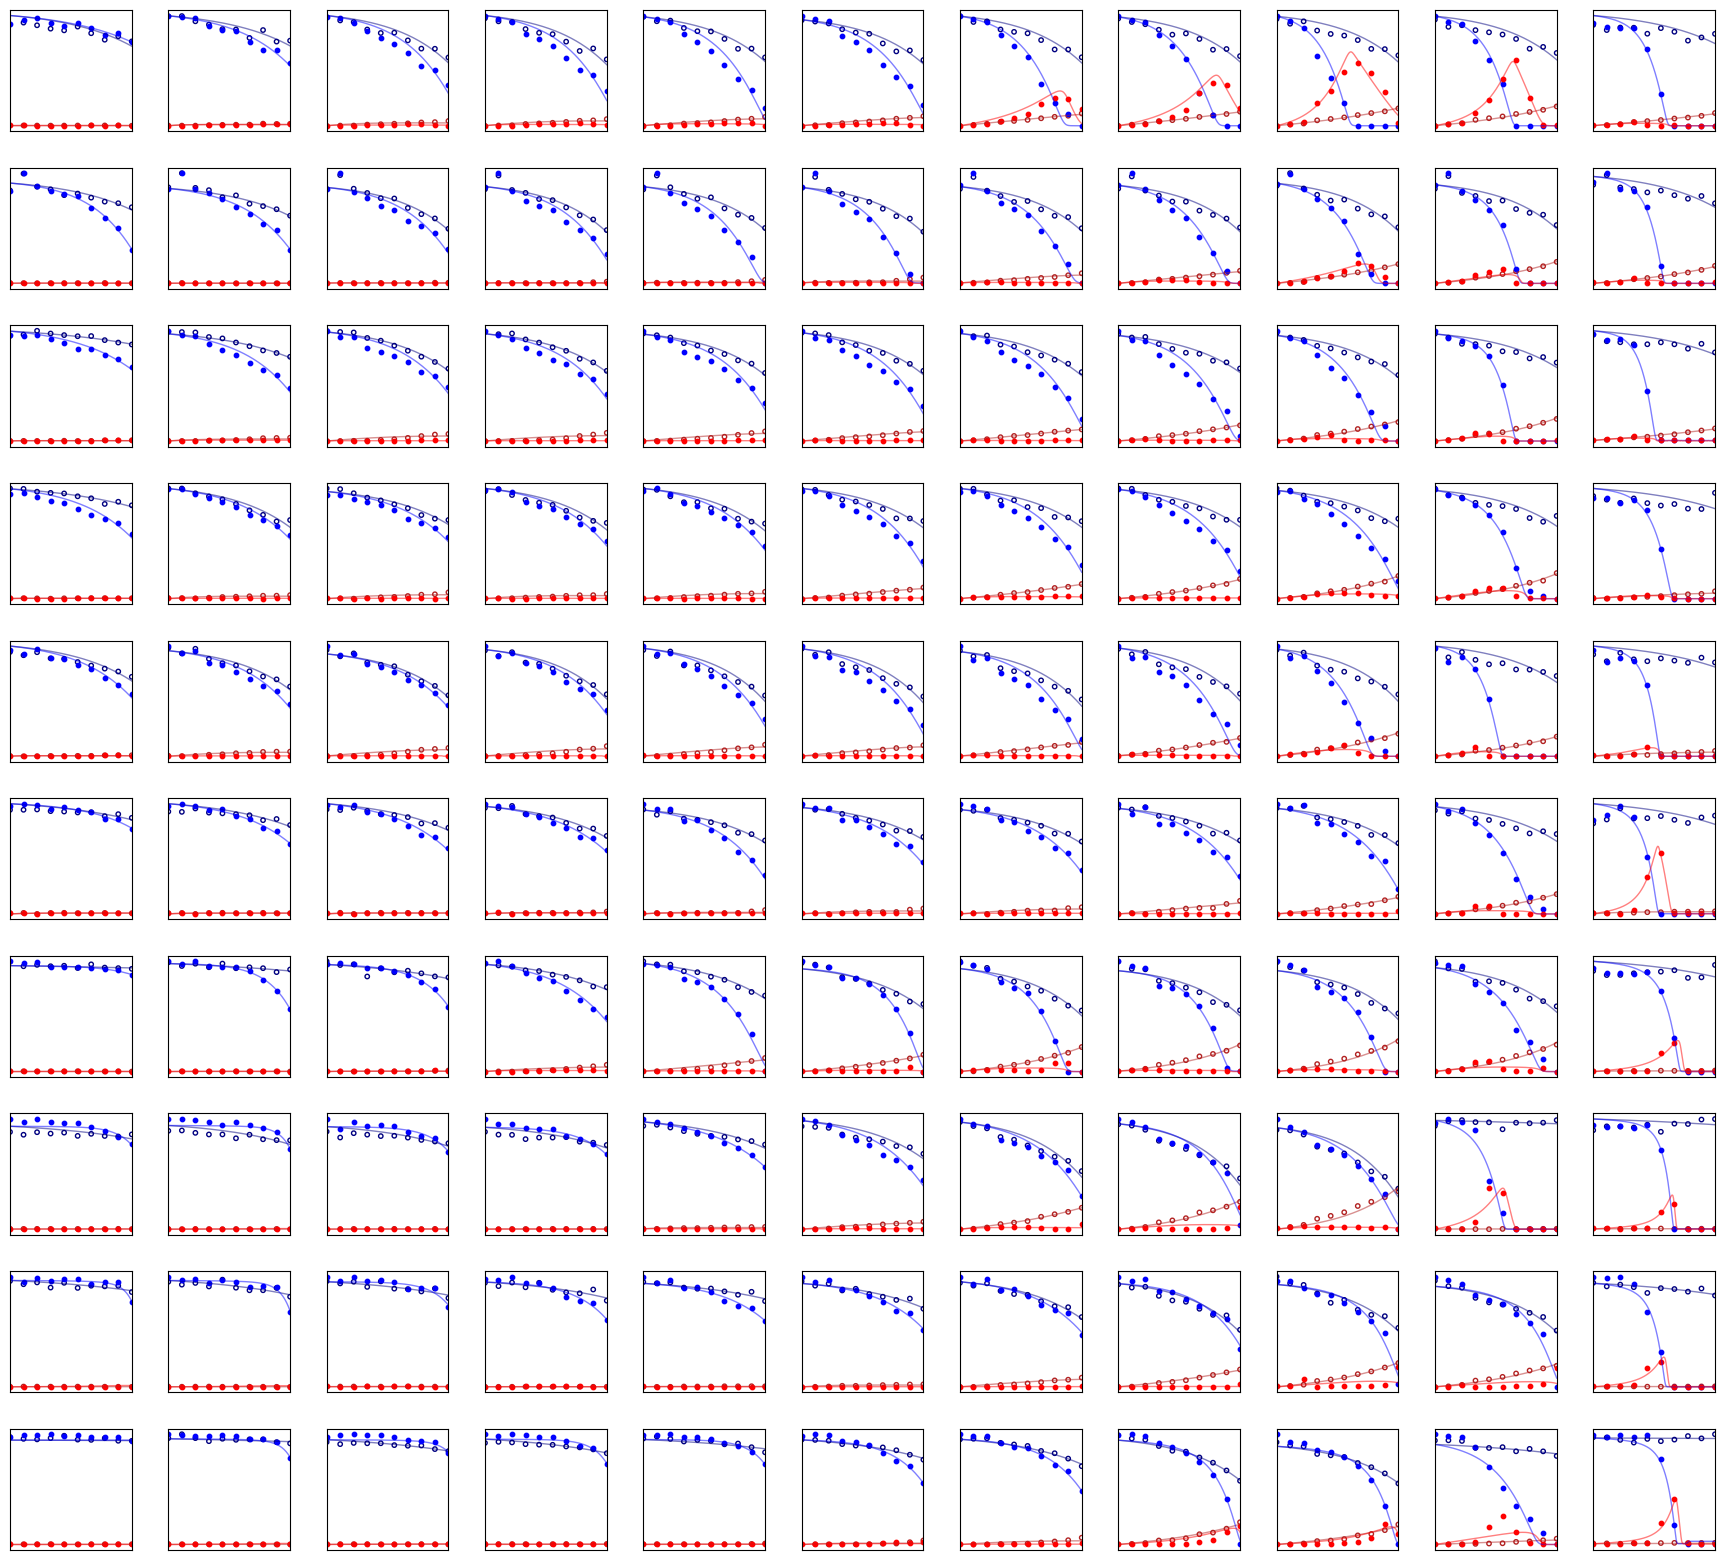

In [210]:

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

x_0 = 0.1
A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
mu = 0
dt = 0.05
T = 9
N = int(T/dt)

param_values = np.zeros((10,11,5))

for native in range(10): 
    for pert in range(11):  

        sample = samples_from_soils(soils[native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        def model_drug(t, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I = simulate_v2(x_0, A_0, I_0, 0,
                                 r_A, r_I, K_A, K_I, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        
        initial_guess = [1.0, 1.0]
        bounds = ([0.01, 0.01,], [10, 10])
        
        popt, pcov = curve_fit(model_drug, t_data, y_data_drug, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][0] = popt[0]
        param_values[native, pert][1] = popt[1]
        x, A, I = simulate_v2(x_0, A_0, I_0, 0, popt[0], popt[1],  K_A, K_I, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        
        def model(t, gamma_I, r_A, r_I):
            indices = np.linspace(0, int(9/dt-1), 10).astype(int)
            _, A, I = simulate_v2(x_0, A_0, I_0, gamma_I, 
                                 r_A, r_I, K_A, K_I, mu, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [1.0, 1.0, 0.1]
        bounds = ([0.001, 0.001, 0.001], [100, 10, 10])
        
        popt, pcov = curve_fit(model, t_data, y_data, 
                              p0=initial_guess, 
                              bounds=bounds,
                              maxfev=100000)
        
        param_values[native, pert][2] = popt[0]
        param_values[native, pert][3] = popt[1]
        param_values[native, pert][4] = popt[2]
        
        x, A, I = simulate_v2(x_0, A_0, I_0, popt[0],
                              popt[1], popt[2], K_A, K_I, mu, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

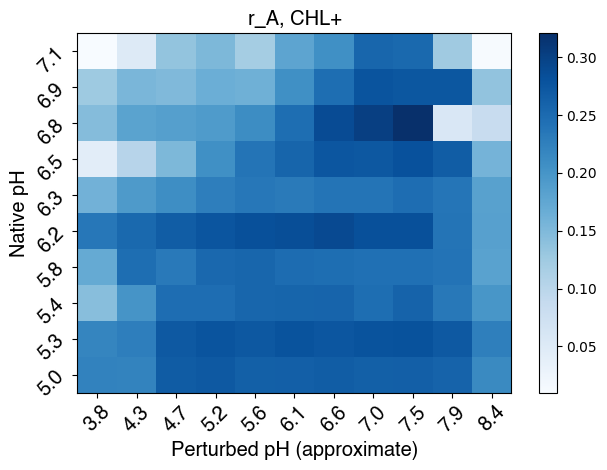

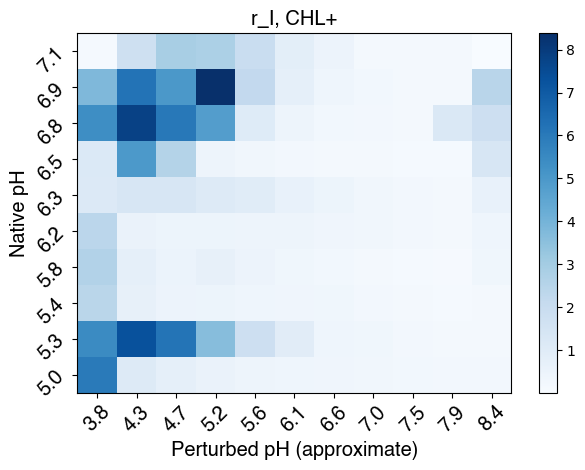

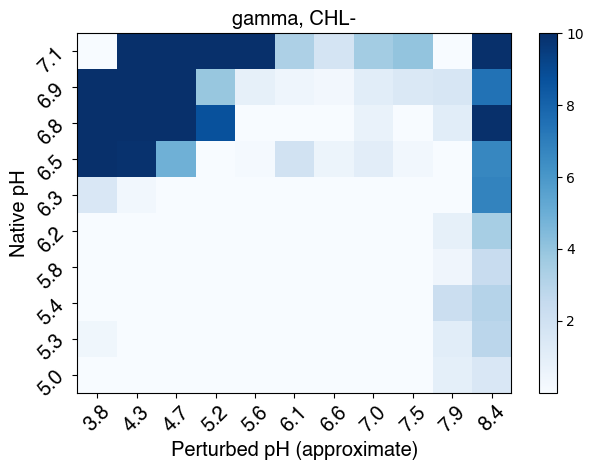

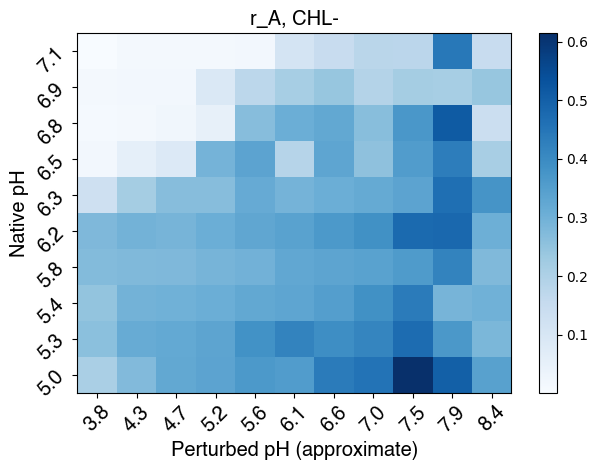

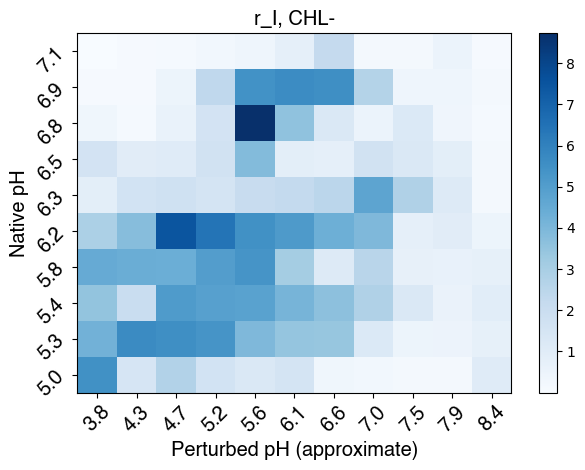

(8, 10):  [0.05652113 1.19216587 1.06738825 0.51259048 0.34344261]
(7,  7):  [0.2746912  0.18509787 0.5346981  0.33000352 0.75117281]
(2,  2):  [2.26672799e-01 7.32751809e+00 1.00000000e-03 3.12687061e-01
 5.66101472e+00]


In [212]:

from mgsa.helpers import plot
plot(param_values[:,:,0], 'r_A, CHL+')
plot(param_values[:,:,1], 'r_I, CHL+')
plot(param_values[:,:,2], 'gamma, CHL-', vmax = 10)
plot(param_values[:,:,3], 'r_A, CHL-')
plot(param_values[:,:,4], 'r_I, CHL-')

print('(8, 10): ', param_values[7,9,:])
print('(7,  7): ', param_values[6,6,:])
print('(2,  2): ', param_values[1,1,:])

param_1 = param_values[1,1,:]
param_2 = param_values[6,6,:]
param_3 = param_values[7,9,:]

K_A 0.12805728507806335
K_I 0.10119804425857548
x_0 0.10483585025583735


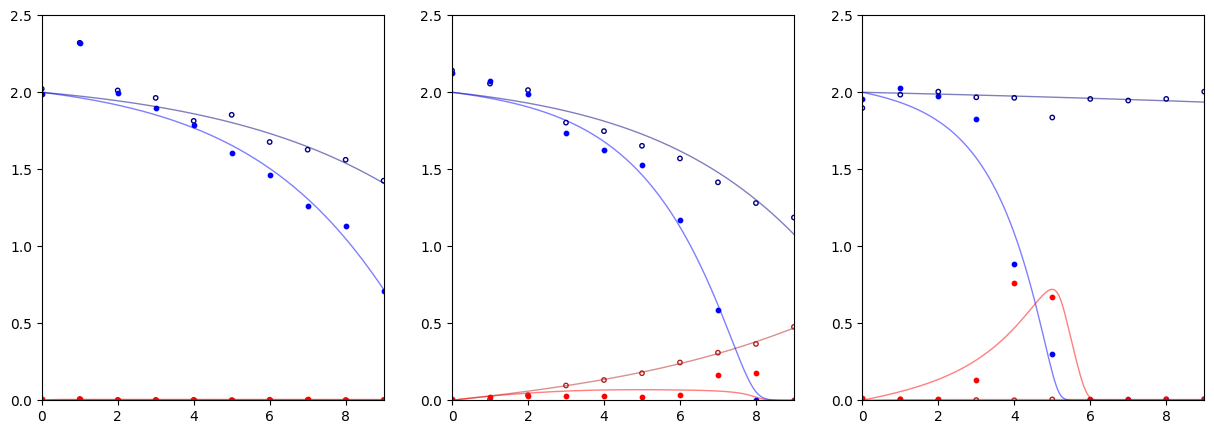

In [217]:
t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

#x_0 = 1
mu = 0
A_0 = 2
I_0 = 0

dt = 0.05
T = 9
N = int(T/dt)

t = np.linspace(0, T, int(T/dt))

## first gather data for 3 cases 

native = 1
pert = 1

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_1 = A_data_drug/3
I_data_drug_1 = I_data_drug/3
y_data_drug_1 = np.concatenate([A_data_drug_1, I_data_drug_1])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_1 = A_data/3
I_data_1 = I_data/3
y_data_1 = np.concatenate([A_data_1, I_data_1])

native = 6
pert = 6

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_2 = A_data_drug/3
I_data_drug_2 = I_data_drug/3
y_data_drug_2 = np.concatenate([A_data_drug_2, I_data_drug_2])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_2 = A_data/3
I_data_2 = I_data/3
y_data_2 = np.concatenate([A_data_2, I_data_2])

native = 7
pert = 9

sample = samples_from_soils(soils[native])[pert]
        
function = get_function(sample, drug = 'CHL')
A_data_drug = np.zeros(10)
I_data_drug = np.zeros(10)
for i in range(3):
    A_data_drug += function[i]
    I_data_drug += function[i + 3]
A_data_drug_3 = A_data_drug/3
I_data_drug_3 = I_data_drug/3
y_data_drug_3 = np.concatenate([A_data_drug_3, I_data_drug_3])

function = get_function(sample)
A_data = np.zeros(10)
I_data = np.zeros(10)
for i in range(3):
    A_data += function[i]
    I_data += function[i + 3]
A_data_3 = A_data/3
I_data_3 = I_data/3
y_data_3 = np.concatenate([A_data_3, I_data_3])

y_data = np.concatenate([y_data_drug_1, y_data_1, y_data_drug_2, y_data_2, y_data_drug_3, y_data_3])

##now create a simulation for the model to compare with

def model(t, K_A, K_I, x_0):
    
    
    indices = np.linspace(0, int(9/dt-1), 10).astype(int)
    
    #first simulate case 1 with drug
    _, A, I = simulate_v2(x_0, A_0, I_0, 0,
                            param_1[0], param_1[1], K_A, K_I, mu, dt, T)
    
    A_1_drug = A[indices]
    I_1_drug = I[indices]
    
    #next simulate case 1 with no drug
    _, A, I = simulate_v2(x_0, A_0, I_0, param_1[2], 
                            param_1[3], param_1[4], K_A, K_I, mu, dt, T)
    A_1 = A[indices]
    I_1 = I[indices]
    
    #next simulate case 2 with drug
    _, A, I = simulate_v2(x_0, A_0, I_0, 0,
                            param_2[0], param_2[1], K_A, K_I, mu, dt, T)
    
    A_2_drug = A[indices]
    I_2_drug = I[indices]
    
    #next simulate case 2 with no drug
    _, A, I = simulate_v2(x_0, A_0, I_0, param_2[2],
                            param_2[3], param_2[4], K_A, K_I, mu, dt, T)
    A_2 = A[indices]
    I_2 = I[indices]
    
    #next simulate case 3 with drug
    _, A, I = simulate_v2(x_0, A_0, I_0, 0,
                            param_3[0], param_3[1], K_A, K_I, mu, dt, T)
    
    A_3_drug = A[indices]
    I_3_drug = I[indices]
    
    #next simulate case 3 with no drug
    _, A, I = simulate_v2(x_0, A_0, I_0, param_3[2], 
                            param_3[3], param_3[4], K_A, K_I, mu, dt, T)
    A_3 = A[indices]
    I_3 = I[indices]
    
    
    
    
    return np.concatenate([A_1_drug, I_1_drug, A_1, I_1, A_2_drug, I_2_drug, A_2, I_2, A_3_drug, I_3_drug, A_3, I_3])


t_data = np.linspace(0,119, 120)
initial_guess = [0.2, 0.2, 0.2]
bounds = ([0.01, 0.01, 0.01], [10, 10, 10])

popt, pcov = curve_fit(model, t_data, y_data, 
                        p0=initial_guess, 
                        bounds=bounds,
                        maxfev=100000)


#collect simulated data 

_, A_1_drug, I_1_drug = simulate_v2(popt[2], A_0, I_0, 0, param_1[0], param_1[1], popt[0], popt[1], mu, dt, T)
_, A_1, I_1 = simulate_v2(popt[2], A_0, I_0, param_1[2], param_1[3], param_1[4], popt[0], popt[1], mu, dt, T)

_, A_2_drug, I_2_drug = simulate_v2(popt[2], A_0, I_0, 0, param_2[0], param_2[1], popt[0], popt[1], mu, dt, T)
_, A_2, I_2 = simulate_v2(popt[2], A_0, I_0, param_2[2], param_2[3], param_2[4], popt[0], popt[1], mu, dt, T)

_, A_3_drug, I_3_drug = simulate_v2(popt[2], A_0, I_0, 0, param_3[0], param_3[1], popt[0], popt[1], mu, dt, T)
_, A_3, I_3 = simulate_v2(popt[2], A_0, I_0, param_3[2], param_3[3], param_3[4], popt[0], popt[1], mu, dt, T)


##plot everything 

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

t_scatter = np.linspace(0, 9, 10)
t = np.linspace(0,9,N)

ax = axs[0]

ax.plot(t, A_1_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_1_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_1, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_1, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_1, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_1, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_1, color='Blue', s=10)
ax.scatter(t_scatter, I_data_1, color='Red', s=10)
ax.set_xlim(0,9)
ax.set_ylim(0,2.5)


ax = axs[1]

ax.plot(t, A_2_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_2_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_2, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_2, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_2, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_2, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_2, color='Blue', s=10)
ax.scatter(t_scatter, I_data_2, color='Red', s=10)
ax.set_xlim(0,9)
ax.set_ylim(0,2.5)

ax = axs[2]

ax.plot(t, A_3_drug, color='navy', alpha=0.5, linewidth=1)
ax.plot(t, I_3_drug, color='firebrick', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_drug_3, color='navy', s=10, facecolors = 'none')
ax.scatter(t_scatter, I_data_drug_3, color='firebrick', s=10, facecolors = 'none')

ax.plot(t, A_3, color='Blue', alpha=0.5, linewidth=1)
ax.plot(t, I_3, color='Red', alpha=0.5, linewidth=1)
ax.scatter(t_scatter, A_data_3, color='Blue', s=10)
ax.scatter(t_scatter, I_data_3, color='Red', s=10)
ax.set_xlim(0,9)
ax.set_ylim(0,2.5)


print('K_A', popt[0])
print('K_I', popt[1])
print('x_0', popt[2])


# Another Idea: Don't fit drug data at all, just use the same parameter values but set gamma = 0. 